# Deep Learning with PyTorch

Classical machine learning relies on using statistics to determine relationships between features and labels, and can be very effective for creating predictive models. However, a massive growth in the availability of data coupled with advances in the computing technology required to process it has led to the emergence of new machine learning techniques that mimic the way the brain processes information in a structure called an artificial neural network.

PyTorch is a Python-based open source machine learning framework that leverages the power of graphics processing units (GPUs) to provide a high level of performance for the processing of tensor objects, which can be visualized as multidimensional arrays. PyTorch can be used to create and train neural networks with high performance levels for deep learning tasks. 

In this notebook, we'll explore the basics of using TensorFlow to create a simple DNN to classify Fashion MNIST dataset. We'll build a neural image classifier using the Fashion MNIST dataset, the aim will be to train a network which can identify various types of clothing based on the low-resolution 28x28 pixel images in this dataset.

let's start by importing the pytorch libraries we're going to use. We will start by installing pytorch.You can do this using the pip package manager.

In [1]:
!pip3 install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now we can import `torch` library and check the version, we will import other libraries later on as we need them.

In [2]:
import torch
torch.__version__

'2.0.0+cu118'

We will load the Fashion MNIST dataset using the `torch.vision` library, and then create training, validation, test datasets, and define data loaders for loading the data in batches during training and evaluation.

In [3]:
from torchvision import datasets, transforms

# Define a transform to normalize the data to [0,1]
transform = transforms.ToTensor()

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)

# Split the training data into validation and training sets
valid_size = 5000
train_size = len(trainset) - valid_size
trainset, validset = torch.utils.data.random_split(trainset, [train_size, valid_size])

# create a training and validation data loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)

# Download and load the test data and create a testloader
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

100%|██████████| 26421880/26421880 [00:03<00:00, 8462049.65it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 143993.08it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2752914.47it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6559014.88it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In the above code, we downloaded the Fashion MNIST dataset from `torchvision.datasets`, which is a mdule that provides many built-in datasets for computer vision tasks, including Fashion MNIST.

We created data loaders for training, testing, and validation sets with a batch size of 64. We splited the training set into two subsets with 5000 samples for validation and the rest for training.

`torch.utils.data.DataLoader` is a class that provides an iterable over a dataset. It can handle batching, shuffling, and multiprocessing of data loading. It can also work with both map-style and iterable-style datasets. A DataLoader takes a dataset object as an argument, and optionally a sampler, a batch size, a number of workers, and other parameters.

Now, let's load one batch of data from the `trainloader` object that we created earlier. The `trainloader` is an iterable, so we can use the `next` function to get a batch. Each batch is a list of two items: a list of 64 images (which is the batch size we defined), and a list of 64 labels. We can see the shape of the image tensor, and the labels for the 64 images.

In [4]:
image, label = next(iter(trainloader))

image.shape, label.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

Images are stored in tensors with the dimensions: (batch size, color channels, height, width). In this case, the images are grayscale, so there is just one color channel. The images are 28x28 pixels, so the height and width are both 28.

We can visually check the content of the images and labels using `matplotlib`. Let's have a look at one of the images in the batch.

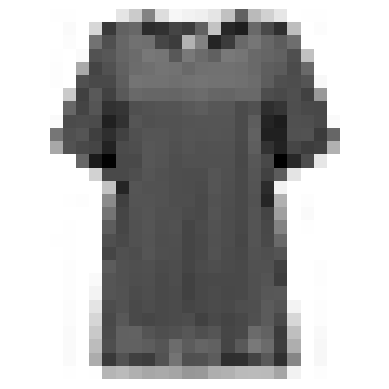

In [5]:
import matplotlib.pyplot as plt
# permute the dimensions of the image to move the color channels to the last dimension
# this is because matplotlib expects the image to be HxWxC (H=height x W=width x C=color channel), \
# while pytorch has it as the first dimension as CxHxW (C=color channel, H=height, W=width)
plt.imshow(image[1].permute(1, 2, 0).squeeze(), cmap="binary")
plt.axis('off')
plt.show()

Let's get the classes names from the dataset object. We need this to map the numeric label in the dataset to the actual classes.

In [6]:
class_names = trainset.dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Now we can use the class_names list to get the label for the image in the batch that we loaded in the previous step.

In [7]:
class_names[label[1]]

'Shirt'

Great! We have loaded the data and are ready to define our neural network model.

## Define a neural network



Let's define a neural network that consists of four fully connected layers, using the `torch.nn` package from PyTorch. 

The first layer being a flattening layer that converts the 28x28 pixel input images into 784 pixel (28*28) vectors.

The subsequent layers are linear layers followed by ReLU activation functions. The `nn.Linear` class takes as parameters the size of the input features and the size of the output features, and creates a linear transformation function with the given shape of weights and biases. The number of input features of a layer must match the number of output features of the previous layer. We choose the number of input and output features for each layer based on the structure that we want to create for our neural network.

The last layer is also a linear layer, but it has 10 output features, because we want to output 10 scores, one for each class. 

In [8]:
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(), # this will flatten the image batches as torch.Size([64, 784])
    
    nn.Linear(784, 256),
    nn.ReLU(),

    nn.Linear(256, 128),
    nn.ReLU(),

    nn.Linear(128, 64),
    nn.ReLU(),

    nn.Linear(64, 10)
)

## Train the model



Once the model is created, we can check its structure by simply printing it. 
We can also use the `parameters` function to get the weights and biases of each layer. if we want to get the weights and biases of a specific layer, we can use the `state_dict` function. We can manually set the weights and biases of a layer using the `load_state_dict` function.

Now let's create an object for the Cuda device, and move the model parameters to the GPU device. And print the model to view it's structure.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, model.to(device)

(device(type='cuda'),
 Sequential(
   (0): Flatten(start_dim=1, end_dim=-1)
   (1): Linear(in_features=784, out_features=256, bias=True)
   (2): ReLU()
   (3): Linear(in_features=256, out_features=128, bias=True)
   (4): ReLU()
   (5): Linear(in_features=128, out_features=64, bias=True)
   (6): ReLU()
   (7): Linear(in_features=64, out_features=10, bias=True)
 ))

Then, we define the loss function and the optimizer. We use the `CrossEntropyLoss` function as the loss function, which is suitable for classification problems with multiple classes. We use the `Adam` optimizer, which is a variant of the stochastic gradient descent algorithm. We pass the model parameters to the optimizer so that it can update the weights of the model during training.

Let's train our model for 10 epochs. We create a variable epochs to store the number of epochs.

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

Let's define a function for training the model. 

We will create varaibles to store the loss and accuracy for each epoch, and then iterate over the number of epochs, loading a batch of images and labels at a time from the training set.

In [11]:
# Define empty lists to store training losses and accuracies
train_losses = []
train_accuracy = []

# Define a function named train that takes an epoch number as input
def train(epoch):

  # Print the current epoch number
  print('\nEpoch : %d'%epoch)

  # Set the model to training mode
  model.train()

  # Initialize variables to keep track of running loss, number of correct predictions, and number of samples
  running_loss = 0
  num_correct = 0
  num_samples = 0

  # Loop over the training data
  for images, labels in trainloader:

    # Move the images and labels to the device (CPU or GPU)
    images, labels = images.to(device), labels.to(device)

    # Forward pass: compute the model's predictions
    outputs = model(images)

    # Compute the loss between the predictions and the true labels
    loss = criterion(outputs,labels)
    
    # Zero the gradients of the model's parameters
    optimizer.zero_grad()
    # Backward pass: compute the gradients of the loss with respect to the model's parameters
    loss.backward()
    # Update the model's parameters using the computed gradients
    optimizer.step()

    # Update the running loss by adding the loss for the mini-batch
    running_loss += loss.item()

    # Compute the number of correct predictions and the number of samples
    _, predicted = outputs.max(1)
    num_samples += labels.size(0)
    num_correct += (predicted == labels).sum().item()

  # Compute the average training loss and accuracy
  train_loss = running_loss / len(trainloader)
  accuracy = 100 * num_correct / num_samples

  # Append the average training loss and accuracy to the lists of losses and accuracies for the epochs
  train_accuracy.append(accuracy)
  train_losses.append(train_loss)

  # Print the average training loss and accuracy for the epoch
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss, accuracy))

Likewise, we'll define a funtion to evaluate the model on the validation set that we created earlier.

In [12]:
# Define empty lists to store training losses and accuracies
val_losses = []
val_accuracy = []

# Define a function named "valid" that performs validation on a PyTorch model
def valid(epoch):
  # Set the model to evaluation mode
  model.eval()

  # Initialize variables to keep track of loss and accuracy
  running_loss = 0
  num_correct = 0
  num_samples = 0

  # Iterate over the validation data using a validloader object
  with torch.no_grad():
    for images, labels in validloader:
      # Load the images and labels onto the device (GPU or CPU)
      images, labels = images.to(device), labels.to(device)

      # Use the model to make predictions on the images
      outputs = model(images)

      # Calculate the loss between the predicted outputs and the actual labels
      loss = criterion(outputs,labels)

      # Update the running loss by adding the current batch loss to it
      running_loss += loss.item()

      # Update the number of correct predictions by comparing the predicted labels with the actual labels
      _, predicted = outputs.max(1)
      num_samples += labels.size(0)
      num_correct += (predicted == labels).sum().item()

  # Calculate the average validation loss and accuracy
  val_loss = running_loss / len(validloader)
  accuracy = 100 * num_correct / num_samples

  # Append the validation loss and accuracy to the lists of losses and accuracies for the epochs
  val_losses.append(val_loss)
  val_accuracy.append(accuracy)

  # Print the validation loss and accuracy
  print('Validation Loss: %.3f | Accuracy: %.3f'%(val_loss, accuracy)) 

Then we call the train and valid funtions to train and evaluate the model for 10 epochs.

In [13]:
for epoch in range(1, epochs+1): 
  train(epoch)
  valid(epoch)


Epoch : 1
Train Loss: 0.566 | Accuracy: 79.625
Validation Loss: 0.400 | Accuracy: 85.260

Epoch : 2
Train Loss: 0.388 | Accuracy: 85.838
Validation Loss: 0.347 | Accuracy: 87.380

Epoch : 3
Train Loss: 0.341 | Accuracy: 87.538
Validation Loss: 0.341 | Accuracy: 87.200

Epoch : 4
Train Loss: 0.317 | Accuracy: 88.391
Validation Loss: 0.331 | Accuracy: 88.080

Epoch : 5
Train Loss: 0.298 | Accuracy: 89.105
Validation Loss: 0.322 | Accuracy: 88.360

Epoch : 6
Train Loss: 0.283 | Accuracy: 89.442
Validation Loss: 0.312 | Accuracy: 88.380

Epoch : 7
Train Loss: 0.269 | Accuracy: 89.993
Validation Loss: 0.304 | Accuracy: 88.780

Epoch : 8
Train Loss: 0.257 | Accuracy: 90.436
Validation Loss: 0.313 | Accuracy: 88.740

Epoch : 9
Train Loss: 0.246 | Accuracy: 90.798
Validation Loss: 0.304 | Accuracy: 88.660

Epoch : 10
Train Loss: 0.237 | Accuracy: 91.129
Validation Loss: 0.303 | Accuracy: 89.420


Let's plot the accuracy values achieved during training for the training and validation sets.

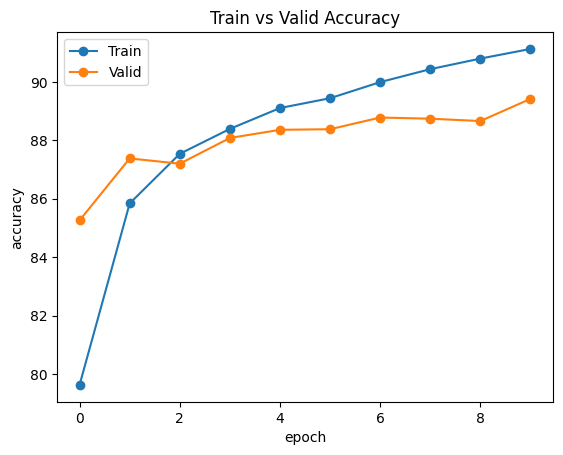

In [14]:
#plot accuracy

plt.plot(train_accuracy,'-o')
plt.plot(val_accuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

And plot the loss values achieved during training for the training and validation sets.

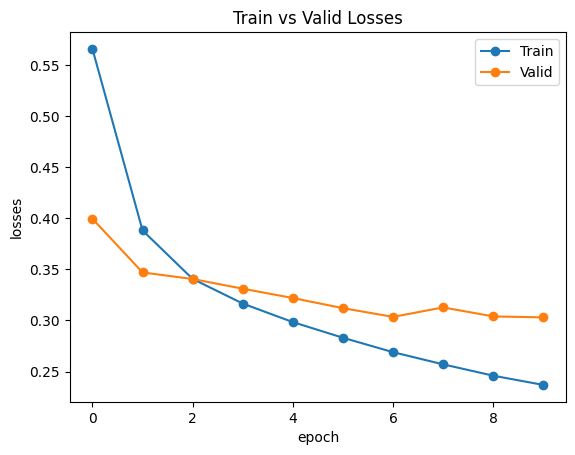

In [15]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

How does the model perform on the test set? Let's evaluate it on the test set.

In [16]:
num_correct = 0
num_samples = 0
model.eval()

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)
        num_samples += labels.size(0)
        num_correct += predicted.eq(labels).sum().item()


    accuracy= 100 * num_correct / num_samples
    print(f"The accuracy of the model is {accuracy:.2f}%")

The accuracy of the model is 88.05%


## Save the trained model
Now we know the model is reasonably accurate, we can save its trained weights for use later for inference. We can simply use the `save` method to save the model object.

In [18]:
torch.save(model, 'models/fashion-mnist-pytorch.pth')

## Learn more

This notebook was designed to help you understand the basic concepts and principles involved in deep neural networks, using a simple PyTorch example. To learn more about PyTorch, take a look at the <a href="https://pytorch.org/tutorials/" target="_blank">PyTorch Tutorials</a>.